In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import itertools
import scipy
from dtaidistance import dtw
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# read in the visitation data
visit_data = pd.read_csv('timeseries_data.csv',index_col='Unnamed: 0')
visit_data['date'] = pd.to_datetime(visit_data['date'], infer_datetime_format=True)
print('The shape is: ',visit_data.shape)
print('The columns are: ',visit_data.columns)
print('The visit types are: ',visit_data['visit_type'].unique())

The shape is:  (1026608, 8)
The columns are:  Index(['ParkName', 'UnitCode', 'ParkType', 'Region', 'state_2', 'date',
       'visit_type', 'number_of_visits'],
      dtype='object')
The visit types are:  ['RecreationVisits' 'NonRecreationVisits' 'RecreationHours'
 'NonRecreationHours' 'ConcessionerLodging' 'ConcessionerCamping'
 'TentCampers' 'RVCampers' 'Backcountry' 'NonRecreationOvernightStays'
 'MiscellaneousOvernightStays']


# Did the 2020 Covid-19 Pandemic have an impact on National Park visitation? Has visitation recovered?
We will address this
question via a time series analysis before and
after March of 2020. We can look at the visitation amounts (day use, tent campers, back
country campers) before and after the day and
see the difference. We can also apply a linear
regression to the pre-covid data to see when/if
the post covid data starts aligning with those
predictions again.

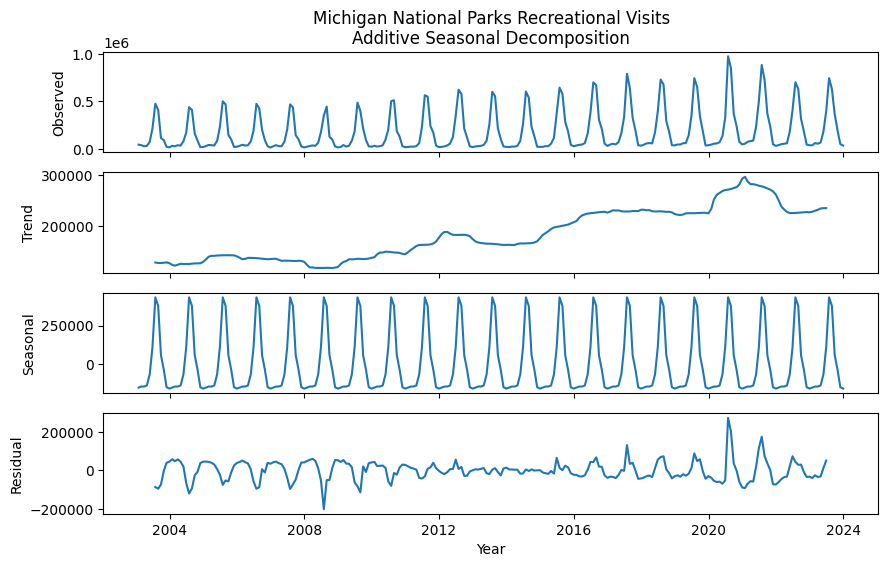

In [4]:
# MI rec visits as an example
state_agg_data=visit_data.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
state_agg_data=state_agg_data[state_agg_data.visit_type=='RecreationVisits']
state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
state_agg_data.fillna(0,inplace=True)
state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
sea_decomp = seasonal_decompose(state_agg_data['MI'], model="additive",period=12) 
# 12 month period has the smoothest trend sign

# let's plot the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(sea_decomp.observed) # original/observed data
axes[0].set_ylabel("Observed")

axes[1].plot(sea_decomp.trend) # trend component
axes[1].set_ylabel("Trend")

axes[2].plot(sea_decomp.seasonal)
axes[2].set_ylabel("Seasonal") # seasonality component 

axes[3].plot(sea_decomp.resid) #  time series with the trend and seasonal components removed
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Year")
_=fig.suptitle("Michigan National Parks Recreational Visits", x=0.513, y=0.95)

In [5]:
def get_data_for_decomp(df:pd.DataFrame,column:str='RecreationVisits')-> pd.DataFrame:
    '''Formats the seasonal data in a better format
    Input:
        df
        column: string, type of visit data e.g. RecreationVisits
    Output:
        df'''
    state_agg_data=df.groupby(['state_2','visit_type','date'])['number_of_visits'].sum().reset_index()
    state_agg_data=state_agg_data[state_agg_data.visit_type==column]
    state_agg_data=state_agg_data.pivot(index='date',columns='state_2',values='number_of_visits')
    state_agg_data.fillna(0,inplace=True)
    state_agg_data.index = pd.to_datetime(state_agg_data.index, infer_datetime_format=True)
    return state_agg_data

def sea_decomp(df:pd.DataFrame)->pd.DataFrame:
    '''Extracts the seasonal & trend components of each column of a df.
    Input:
        df (pd.DataFrame): a df with a date time index, values are daily new cases

    Output:
        pd.DataFrame: each column has the seasonal component of a column.
    '''
    result = None
    for x in df.columns:
        sea_decomp = seasonal_decompose(df[x], model="additive",period=12)
        temp = pd.DataFrame(sea_decomp.seasonal)
        temp2 = pd.DataFrame(sea_decomp.trend)
        name = f'{x} seasonal'
        temp.columns = [name]
        temp2.columns = [f'{x} trend']
        if result is None: # for the first column
            result = temp.join(temp2)
        else:
            result = result.join(temp)
            result = result.join(temp2)
    return result

In [7]:
visit_data.visit_type.unique()

array(['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays'],
      dtype=object)

In [10]:
# recreational visits
sea_comp_insert_data = get_data_for_decomp(visit_data,'RecreationVisits')
rec_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
rec_seasonal_trend_dec.columns = [x + ' recreational visits' for x in rec_seasonal_trend_dec]
# non recreational visits
sea_comp_insert_data = get_data_for_decomp(visit_data,'NonRecreationVisits')
nonrec_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
nonrec_seasonal_trend_dec.columns = [x + ' nonrecreational visits' for x in rec_seasonal_trend_dec]
# tent campers
sea_comp_insert_data = get_data_for_decomp(visit_data,'TentCampers')
tent_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
tent_seasonal_trend_dec.columns = [x + ' tent campers' for x in rec_seasonal_trend_dec]
# rv campers
sea_comp_insert_data = get_data_for_decomp(visit_data,'RVCampers')
rv_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
rv_seasonal_trend_dec.columns = [x + ' rv campers' for x in rec_seasonal_trend_dec]
# backcountry
sea_comp_insert_data = get_data_for_decomp(visit_data,'Backcountry')
bc_seasonal_trend_dec =sea_decomp(sea_comp_insert_data)
bc_seasonal_trend_dec.columns = [x + ' backcountry' for x in rec_seasonal_trend_dec]

# Did the 2008 recession have an impact on National Park visitation? Did visitation rates recover afterwards? How long did it take? 
We will conduct a time series analysis from a pre-December 2007 until March 2020. To see if the Covid-19 pandemic and 2008 recession impacted National park visitor patterns in similar ways, we can apply dynamic time warping. This algorithm can be used to compare how similar the change in visitors was due to these two global events. We will choose a period of a few years before and after the event (most likely 3 as the most recent data in our dataset is 3 years post-covid). For a baseline, we can compare it to a randomly selected time period of the same length.

In [ ]:
#